In [1]:
import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt

from collections import namedtuple
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import data_processing as dp
import model
import model_utilities as util
import vocab
import batch_samplers

In [3]:
import os

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

In [5]:
import importlib

In [6]:
importlib.reload(model)

<module 'model' from '/data/itasarom/diplom/gan_embeddings/GAN/model.py'>

In [7]:
def normalize_embeddings(embeddings):
    EPS = 1e-9
    mean = embeddings[1:].mean(axis=0, keepdims=True)
    se = (embeddings[1:].var(axis=0, keepdims=True)  + EPS )**0.5
#     embeddings
    embeddings = (embeddings - mean)/se
    embeddings[0, :] = 0
    return embeddings

In [8]:
vocab1, all_labels, sents1, labels1 = dp.load_problem(lang='fr', max_sent_length=100)
# vocab2, all_labels, sents2, labels2 = dp.load_problem(lang='es', max_sent_length=100)
# vocab1, all_labels, sents1, labels1 = dp.load_problem(lang='ru')
vocab2, all_labels, sents2, labels2 = dp.load_problem(lang='en', max_sent_length=100)

In [9]:
# vocab1.embeddings.var(axis=0)

In [10]:
vocab1.embeddings = normalize_embeddings(vocab1.embeddings)
vocab2.embeddings = normalize_embeddings(vocab2.embeddings)

In [11]:
# vocab1.embeddings.var(axis=0)

In [12]:
len(vocab1.embeddings), len(vocab2.embeddings)

(47377, 47404)

In [13]:
len(sents1), len(sents2)

(18641, 17860)

In [14]:
torch.cuda.is_available()

True

In [15]:
sent_sampler_1 = batch_samplers.BatchSamplerRegularizer(sents=sents1, labels=labels1, vocab=vocab1, all_labels=all_labels, max_sent_length=None, seed=44)

In [16]:
sent_sampler_2 = batch_samplers.BatchSamplerRegularizer(sents=sents2, labels=labels2, vocab=vocab2, all_labels=all_labels, max_sent_length=None, seed=44)

In [17]:
print(len(sent_sampler_1.sents), len(sent_sampler_2.sents))

18641 17860


In [18]:
embed_sampler_1 = batch_samplers.BatchSamplerDiscriminator(vocab1)

In [19]:
embed_sampler_2 = batch_samplers.BatchSamplerDiscriminator(vocab2)

In [20]:
import IPython


In [21]:
sent_sampler_1.test[0][111]

['nicolas',
 'sarkozy',
 'a',
 'justifié',
 'les',
 'suppressions',
 'de',
 'postes',
 'parmi',
 'les',
 'forces',
 'de',
 'l',
 'ordre',
 'par',
 'la',
 'nécessité',
 'de',
 'faire',
 'des',
 'économies',
 'francois',
 'lo',
 'presti',
 'afp',
 'nicolas',
 'sarkozy',
 'ne',
 'regrette',
 'rien',
 'des',
 'suppression',
 'de',
 'postes',
 'de',
 'policiers',
 'et',
 'de',
 'gendarmes',
 'sous',
 'son',
 'quinquennat',
 'les',
 'justifiant',
 'par',
 'les',
 'conditions',
 'économiques',
 'nicolas',
 'sarkozy',
 'candidat',
 'à',
 'la',
 'primaire',
 'de',
 'la',
 'droite',
 'a',
 'dit',
 'jeudi',
 'ne',
 'pas',
 'regretter',
 'les',
 'réductions',
 'd',
 'effectifs',
 'de',
 'gendarmes',
 'et',
 'policiers',
 'durant',
 'son',
 'quinquennat',
 'expliquant',
 'sur',
 'rmc',
 'bfmtv',
 'qu',
 'il',
 'fallait',
 'faire',
 'des',
 'économies',
 'il',
 'fallait',
 'faire',
 'des',
 'économies',
 'à',
 'la',
 'question',
 'vous',
 'avez',
 'supprimé',
 '12',
 '469',
 'postes',
 'de',
 'genda

In [22]:
sent_sampler_2.test[0][111]

['cnn',
 'heavy',
 'rains',
 'drenched',
 'parts',
 'of',
 'southeast',
 'louisiana',
 'and',
 'southern',
 'mississippi',
 'on',
 'friday',
 'causing',
 'dangerous',
 'floods',
 'that',
 'killed',
 'at',
 'least',
 'three',
 'people',
 'cut',
 'off',
 'an',
 'entire',
 'town',
 'shut',
 'down',
 'highways',
 'and',
 'prompted',
 'numerous',
 'rescues',
 'in',
 'louisiana',
 'all',
 'seven',
 'major',
 'roads',
 'into',
 'greensburg',
 'near',
 'baton',
 'rouge',
 'were',
 'under',
 'water',
 'and',
 'the',
 'small',
 'town',
 'largely',
 'cut',
 'off',
 'according',
 'to',
 'michael',
 'martin',
 'director',
 'of',
 'operations',
 'for',
 'the',
 'st',
 'helena',
 'parish',
 'sheriff',
 's',
 'office',
 'only',
 'large',
 'national',
 'guard',
 'vehicles',
 'have',
 'been',
 'able',
 'to',
 'get',
 'into',
 'and',
 'out',
 'of',
 'town',
 'martin',
 'said',
 'at',
 'least',
 'two',
 'dozen',
 'high',
 'water',
 'rescues',
 'were',
 'carried',
 'out',
 'friday',
 'with',
 'stranded',
 

In [23]:
cls = model.GAN(100, len(all_labels))

In [24]:
torch.cuda.current_device()

0

In [25]:
cls = cls.cuda()

In [165]:
# params = {
#     'save_path': "./model_checkpoint.tc",
#     'save_every':10,
#     'sentence_iterations':200,
#     'discr_iterations':1,
#     'transform_iterations':500,
#     'n_sents_1':128,
#     'n_sents_2':128,
#     'n_discr_1':128,
#     'n_discr_2':128,
#     'n_iter':20
    
# }

# params = {
#     'save_path': "./model_checkpoint.tc",
#     'save_every':10,
#     'sentence_iterations':2,
#     'discr_iterations':1,
#     'transform_iterations':5,
#     'n_sents_1':128,
#     'n_sents_2':128,
#     'n_discr_1':128,
#     'n_discr_2':128,
#     'n_iter':20
    
# }

# params = {
#     'save_path': "./model_checkpoint_2_layers.tc",
#     'save_every':10,
#     'sentence_iterations':200,
#     'discr_iterations':10,
#     'transform_iterations':20,
#     'n_sents_1':128,
#     'n_sents_2':128,
#     'n_discr_1':1024,
#     'n_discr_2':1024,
#     'n_iter':100
    
# }


params = {
    'save_path': "./model_checkpoint_sentences_fr_en_dropout_2.tc",
    'save_every':10,
    'sentence_iterations':50,
    'discr_iterations':10,
    'transform_iterations':25,
    'n_sents_1':256,
    'n_sents_2':256,
    'n_discr_1':1024,
    'n_discr_2':1024,
    'n_iter':500,
    'validate_every':1
    
}

In [35]:
# trainer.global_iterations = 60

In [29]:
# trainer = util.Trainer(cls)

In [30]:
# trainer.restore("./model_checkpoint_sentences_fr_en_dropout_2.tc")
# # cls.train()

In [31]:
# torch.abs(cls.transformation_1.bias - cls.transformation_2.bias).max()[0
# sents1[0]

In [32]:
# vocab1.embeddings[40]
# [k for k in vocab1.transformation if vocab1.transformation[k] == 40 ]

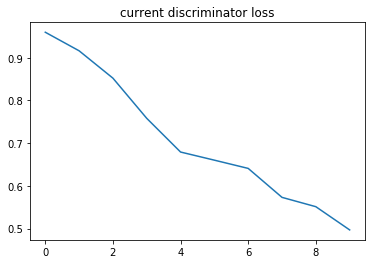

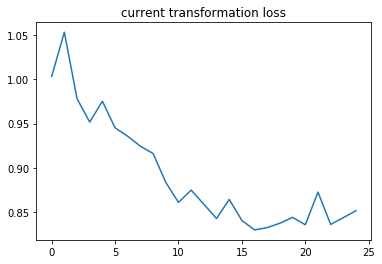

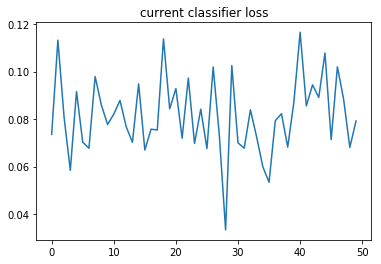

Iter 7500 class 0.08133998513221741, discr0.7087170481681824, transform 0.8917607665061951


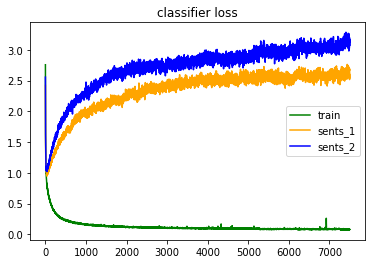

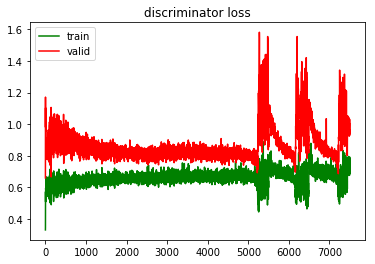

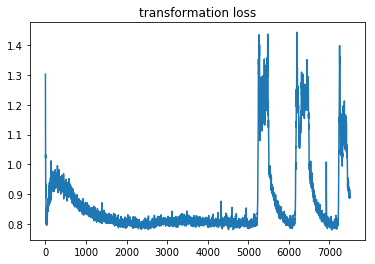

after epoch_id


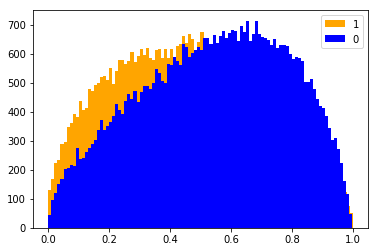

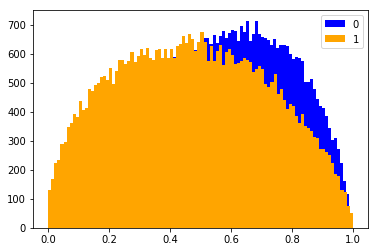

Embedding accuracy  0.440985007543706
Embedding loss  0.9601082534643142
Confusion matrix
 [[19989. 27388.]
 [25596. 21808.]]
Min component variance 0.22890356183052063, median component variance 0.37042784690856934, mean component variance 0.3719099164009094, max c v 0.5045453310012817
Sents1 (697, 1024, 0.6806640625) [2.640175]
Sents2 (680, 1024, 0.6640625) [3.1716986]


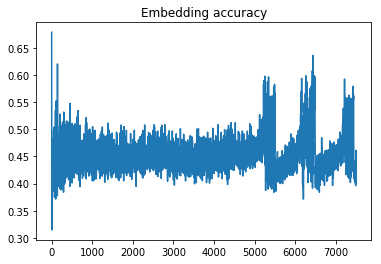

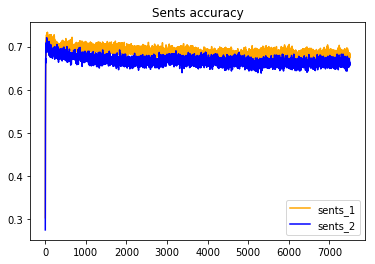

In [503]:
# trainer.t
trainer.train(sent_sampler_1, sent_sampler_2, embed_sampler_1, embed_sampler_2, params)

In [504]:
import pickle

In [506]:
#trainer.model = None

In [510]:
#pickle.dump(trainer, open("trainer_7500_iterations_fr_en.pkl", "wb"))

In [433]:
w1 = cls.transformation_1.weight.data.cpu().numpy()

In [511]:
w2 = cls.transformation_2.weight.data.cpu().numpy()

In [512]:
np.all((w1.T @ w1).argmax(axis=1) == np.arange(w1.shape[0]))

True

In [436]:
np.all((w2.T @ w2).argmax(axis=1) == np.arange(w2.shape[0]))

True

In [437]:
np.diag(w1 @ w1.T)

array([0.27829024, 0.25140294, 0.2911839 , 0.24512388, 0.2698321 ,
       0.25638962, 0.37422696, 0.23755479, 0.3493008 , 0.30277115,
       0.2550723 , 0.44051293, 0.36357835, 0.31526956, 0.22029519,
       0.2424351 , 0.31772122, 0.23279512, 0.19768812, 0.30377936,
       0.33265653, 0.35797632, 0.2795848 , 0.33193085, 0.34771997,
       0.31360468, 0.31019852, 0.36193246, 0.33901817, 0.26675075,
       0.23230222, 0.22332822, 0.24263056, 0.1944418 , 0.17195486,
       0.23777612, 0.40285188, 0.35155642, 0.30340156, 0.35492802,
       0.40897858, 0.4067937 , 0.33543745, 0.27297595, 0.35692453,
       0.409997  , 0.35425687, 0.3019494 , 0.2533723 , 0.27285612,
       0.29025218, 0.29206613, 0.3161155 , 0.30875146, 0.26459643,
       0.2876434 , 0.22593254, 0.33118406, 0.25903493, 0.33163512,
       0.34333923, 0.23103741, 0.37792832, 0.2517286 , 0.32170826,
       0.3545893 , 0.31252664, 0.32583264, 0.23007505, 0.23193449,
       0.20897974, 0.27655977, 0.25862074, 0.20949426, 0.24937

In [438]:
import sklearn
from sklearn.metrics import log_loss, accuracy_score

In [439]:
def build_confusion_matrix(predicted_probs, true_y):
    n_labels = predicted_probs.shape[1]
#     assert true_y.shape == predicted_probs.shape
    result = np.zeros(shape=(n_labels, n_labels))
    
    pred = predicted_probs.argmax(axis=1)
#     true = true_y.argmax(axis=1)
    true = true_y
    
    for pred_cls in range(n_labels):
        for true_cls in range(n_labels):
            result[true_cls, pred_cls] = np.count_nonzero(true[pred == pred_cls] == true_cls)
#     norm = result.sum(axis=1)
#     norm = np.maximum(norm, 1)
#     result /= norm[:, None]
    return result


In [440]:
def get_probs(transformation, model, embeddings, batch_size, use_cuda):
    result = []
#     embed_sum = 0.0
#     squares_sum = 0.0
    embeds = []
    for position in range(0, len(embeddings), batch_size):
        x = embeddings[position:position + batch_size]
        x = torch.autograd.Variable(torch.from_numpy(x)).float()
        if use_cuda:
            x = x.cuda()
        
        x = transformation(x)
        _, probs = model.discriminator.forward(x)
        probs = probs.data.cpu().numpy()
        result.append(probs)
        
        x = x.cpu().data.numpy()
#         embed_sum += x
        embeds.append(x)
    
    result = np.vstack(result)
    z = 1 - result
    result = np.hstack([z, result])
    return result, np.vstack(embeds)

In [441]:
def build_confusion_matrix(predicted_probs, true_y):
    n_labels = predicted_probs.shape[1]
#     assert true_y.shape == predicted_probs.shape
    result = np.zeros(shape=(n_labels, n_labels))
    
    pred = predicted_probs.argmax(axis=1)
#     true = true_y.argmax(axis=1)
    true = true_y
    
    for pred_cls in range(n_labels):
        for true_cls in range(n_labels):
            result[true_cls, pred_cls] = np.count_nonzero(true[pred == pred_cls] == true_cls)
#     norm = result.sum(axis=1)
#     norm = np.maximum(norm, 1)
#     result /= norm[:, None]
    return result


In [442]:
def validate(model, embeddings_1, embeddings_2, batch_size, use_cuda):
    probs_1, t1 = get_probs(model.transform1, model, embeddings_1, batch_size, use_cuda)
    probs_2, t2 = get_probs(model.transform2, model, embeddings_2, batch_size, use_cuda)
    probs = np.vstack([probs_1, probs_2])
    
    pred_1 = probs_1.argmax(axis=1).reshape(-1, 1)
    pred_2 = probs_2.argmax(axis=1).reshape(-1, 1)    
    pred = np.vstack([pred_1, pred_2])
    
    y_true = np.concatenate([np.zeros((len(pred_1),)), np.ones((len(pred_2)))])
    
    
    acc = accuracy_score(y_pred=pred, y_true=y_true)
    loss = log_loss(y_pred=probs, y_true=y_true)
    cm = build_confusion_matrix(probs, y_true)
    
    plt.hist(probs[y_true == 1, 1], bins=100, label="1", color='orange')
    plt.hist(probs[y_true == 0, 1], bins=100, label="0", color='blue')
    
    plt.legend()
    plt.show()
    

    plt.hist(probs[y_true == 0, 1], bins=100, label="0", color='blue')
    plt.hist(probs[y_true == 1, 1], bins=100, label="1", color='orange')
    
    plt.legend()
    plt.show()
    
    t = np.vstack([t1, t2])
    
    return acc, loss, cm, probs, y_true , t
    

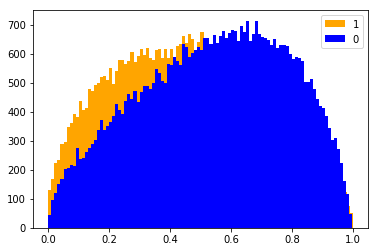

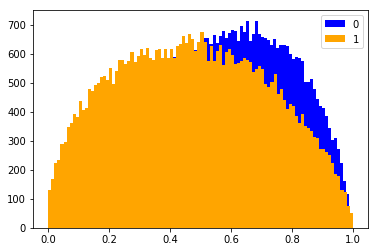

Accuracy  0.440985007543706
Loss  0.9601082534643142
Confusion matrix
 [[19989. 27388.]
 [25596. 21808.]]
Min component variance 0.22890356183052063, median component variance 0.37042784690856934, mean component variance 0.3719099164009094, max c v 0.5045453310012817
Total length  94781


In [513]:
cls.eval()
result = validate(cls, vocab1.embeddings, vocab2.embeddings, 200, use_cuda=True)
print("Accuracy ", result[0])
print("Loss ", result[1])
print("Confusion matrix\n", result[2])
vars = result[-1].var(axis=0)
print("Min component variance {}, median component variance {}, mean component variance {}, max c v {}".format(
        min(vars), np.median(vars), np.mean(vars), max(vars)
    ))
print("Total length ", len(result[-1]))

In [444]:
# cls.discriminator.actual_model.zero_grad()

In [445]:
embeds = result[-1]

In [446]:
embeds = normalize_embeddings(embeds)

In [447]:
embeds1 = embeds[:len(vocab1.embeddings)]
embeds2 = embeds[len(vocab1.embeddings):]

/data/itasarom/torch/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


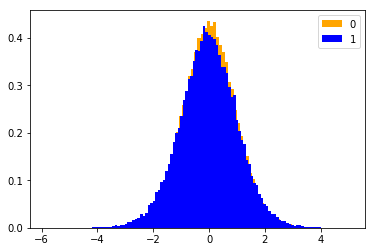

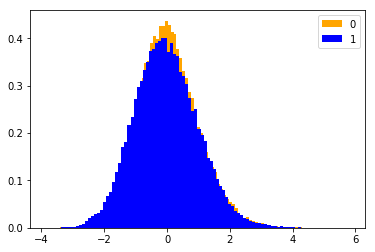

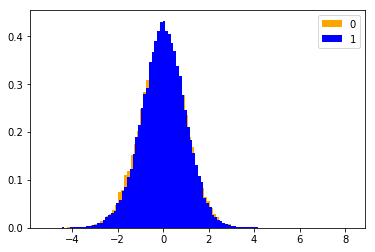

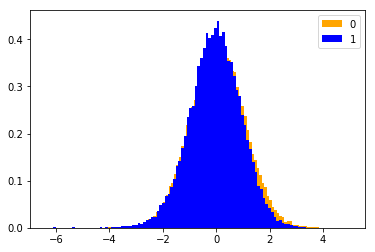

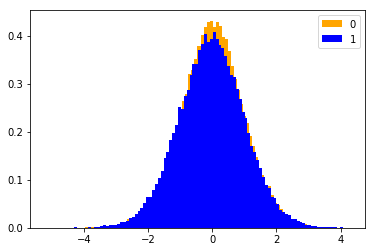

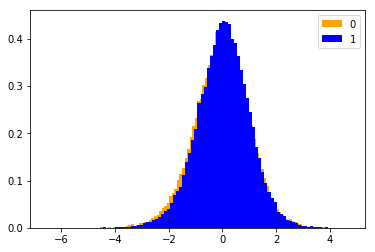

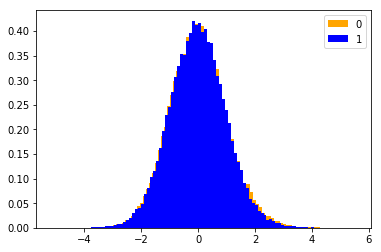

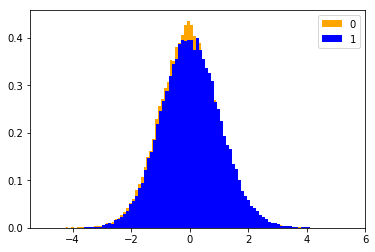

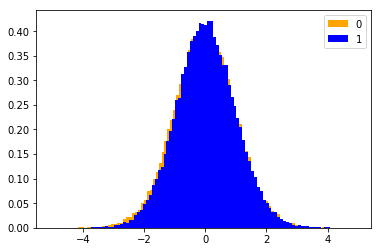

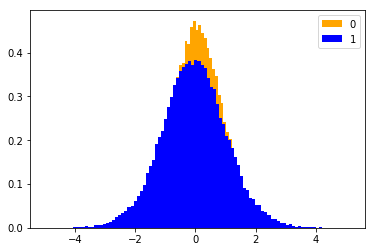

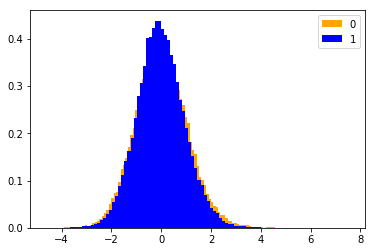

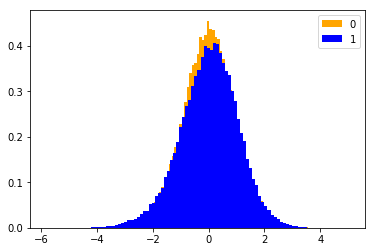

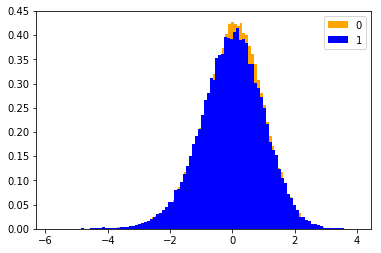

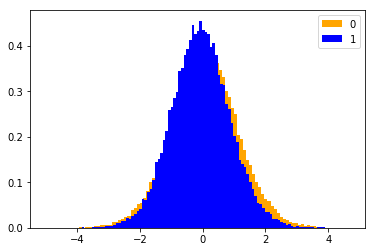

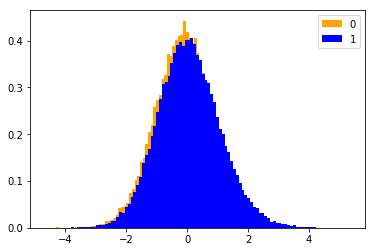

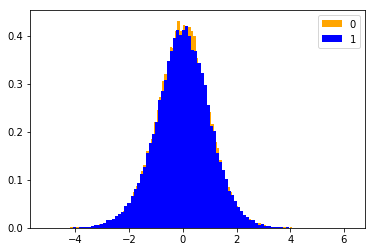

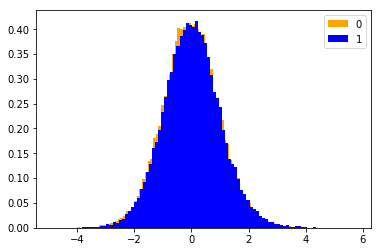

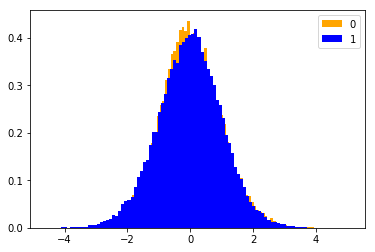

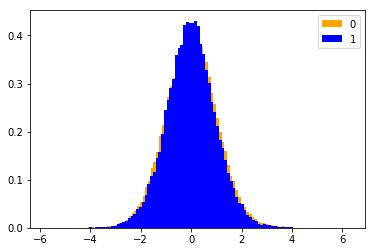

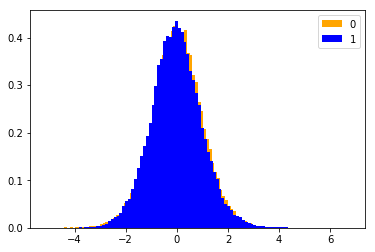

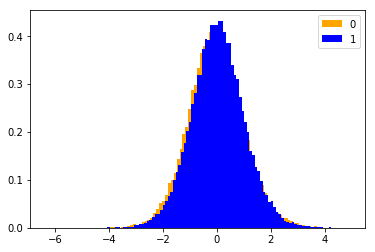

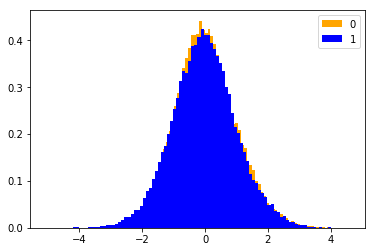

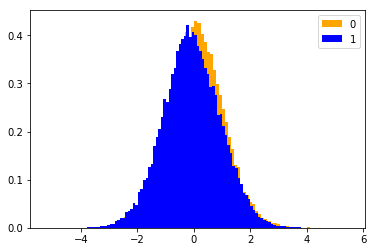

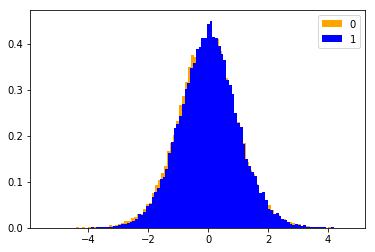

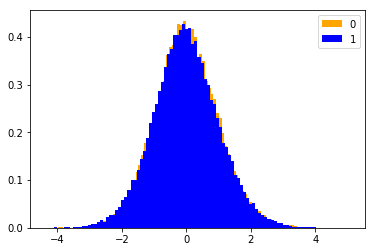

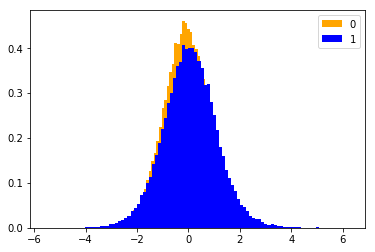

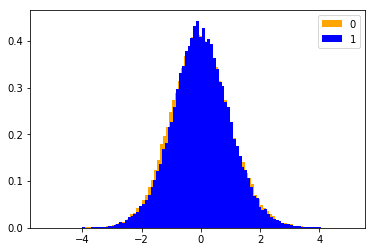

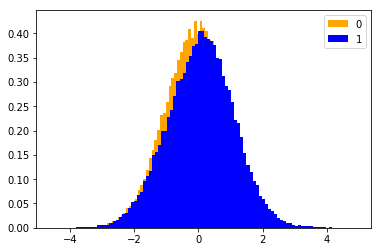

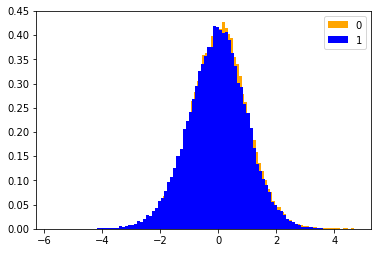

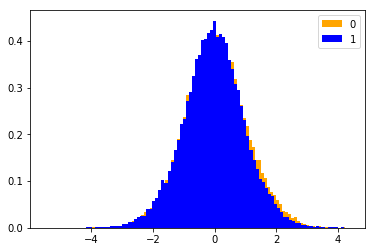

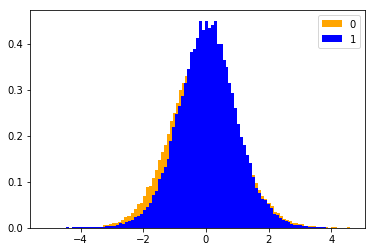

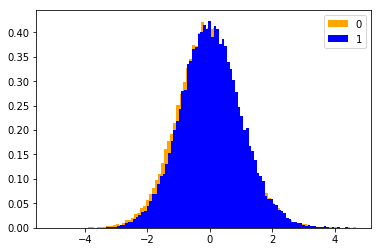

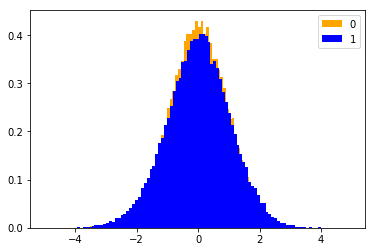

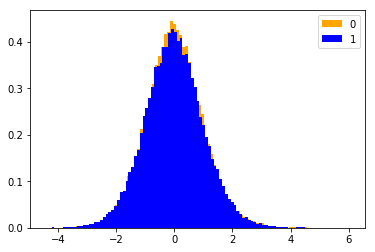

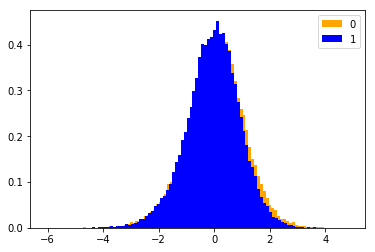

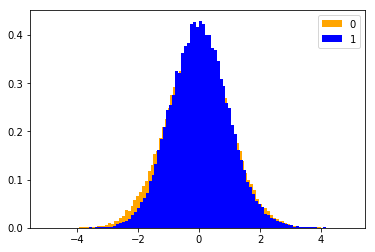

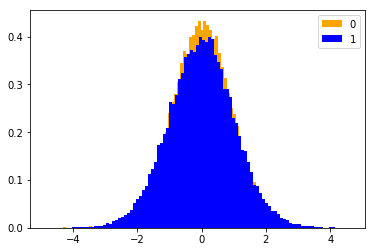

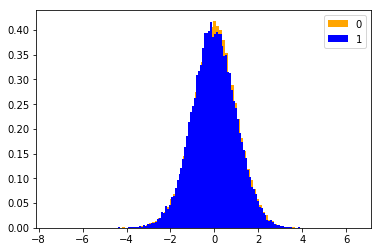

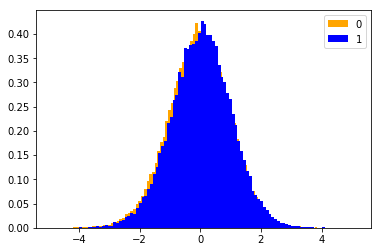

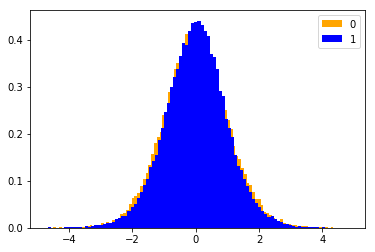

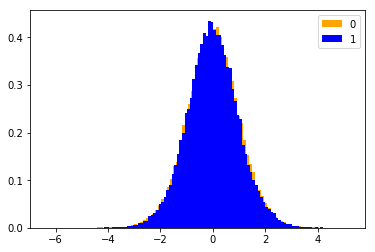

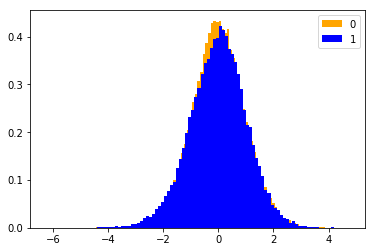

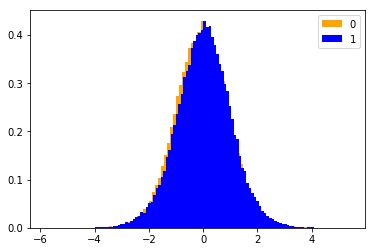

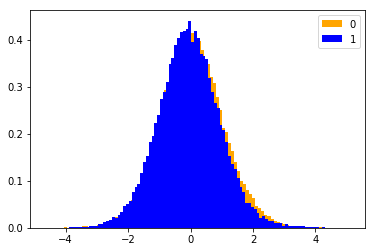

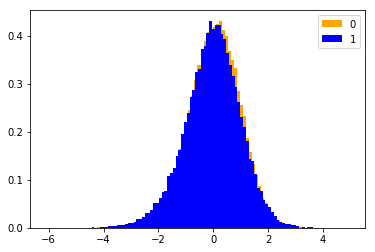

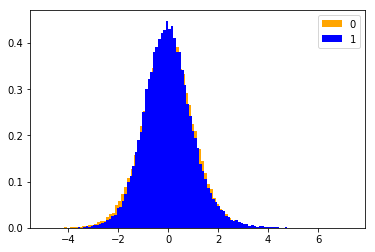

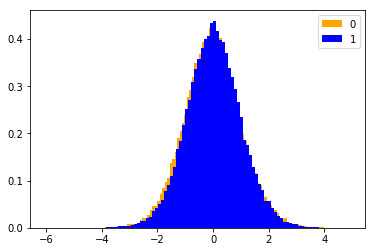

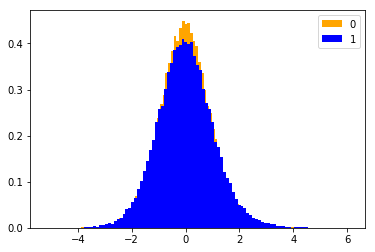

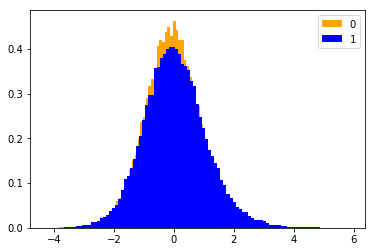

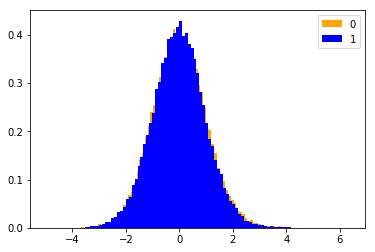

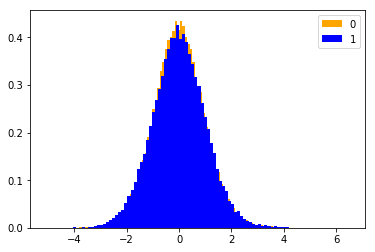

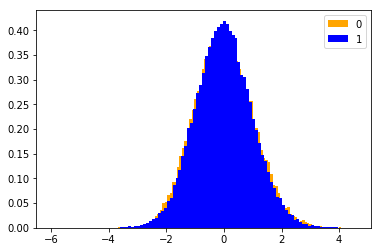

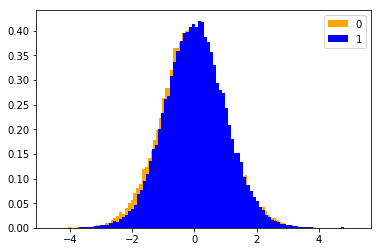

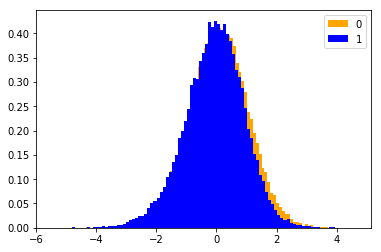

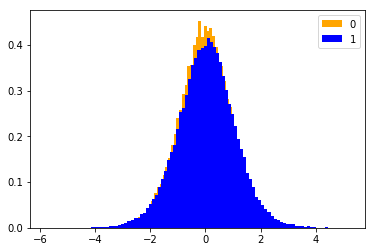

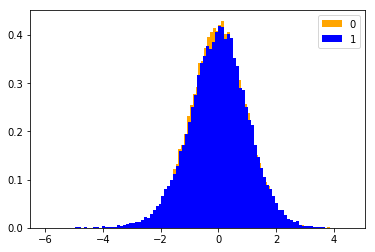

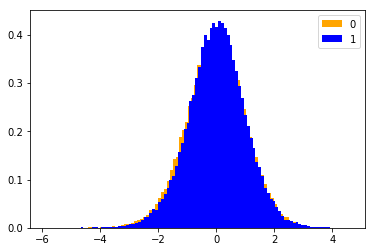

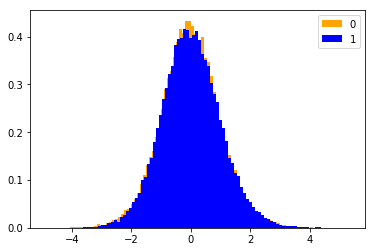

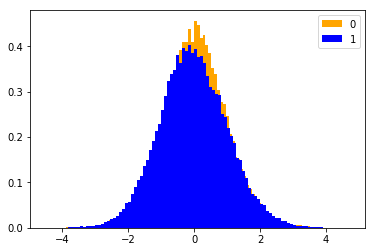

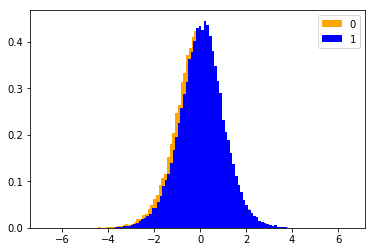

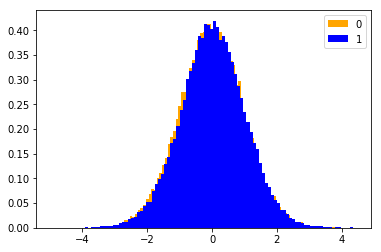

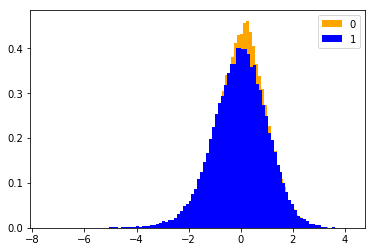

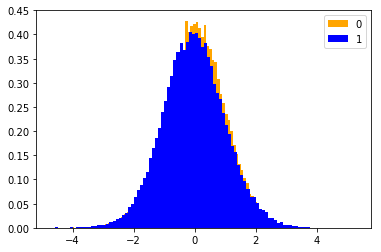

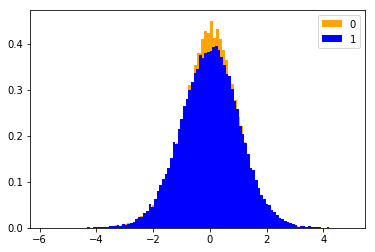

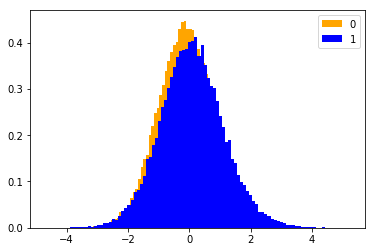

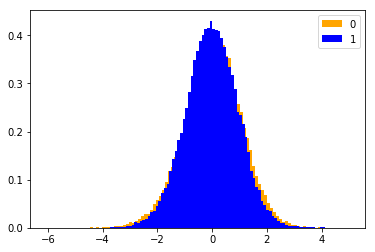

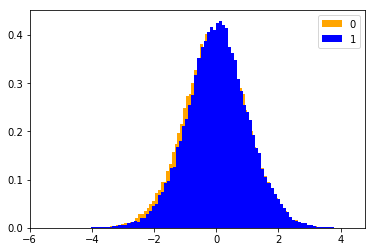

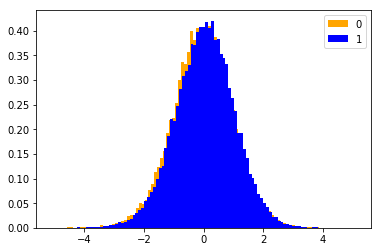

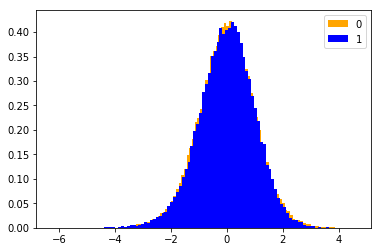

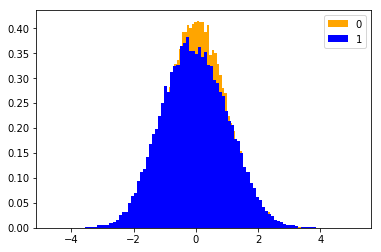

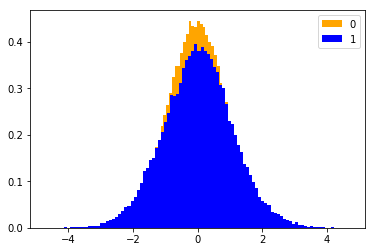

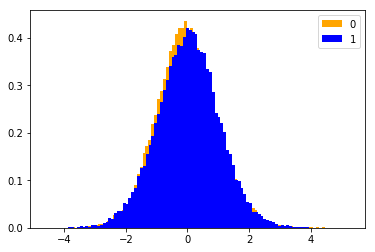

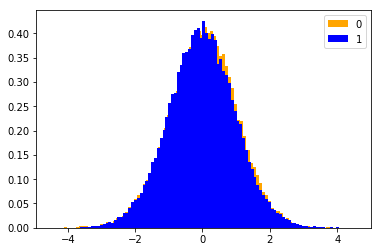

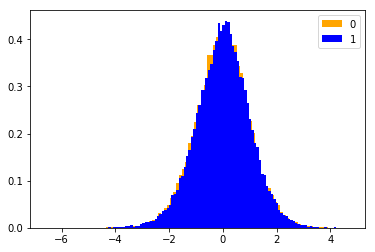

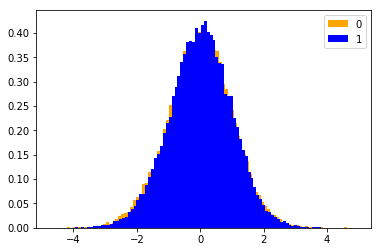

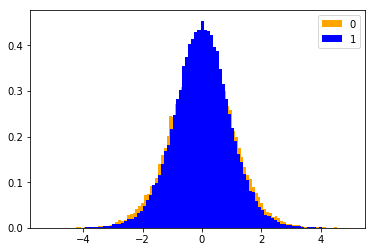

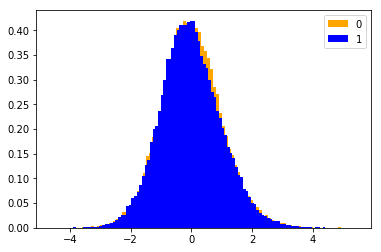

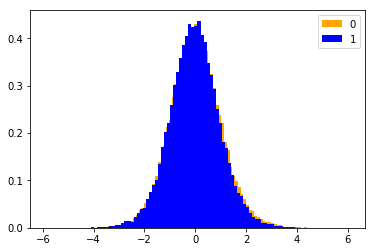

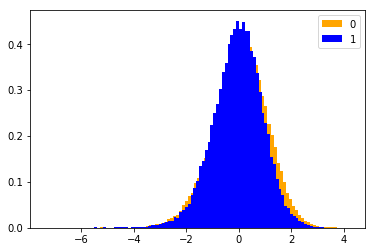

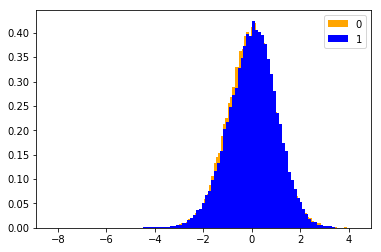

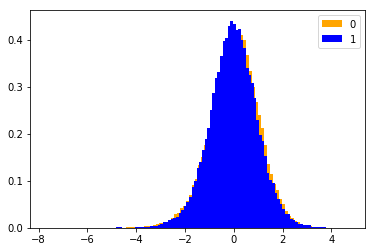

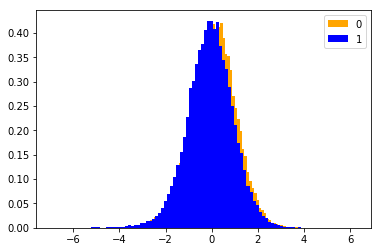

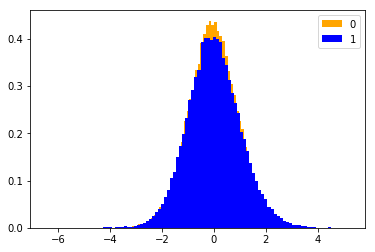

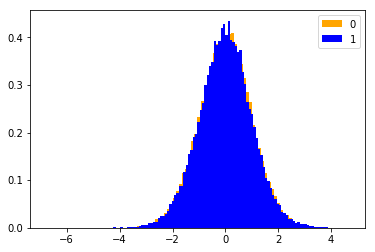

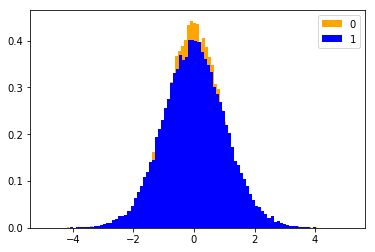

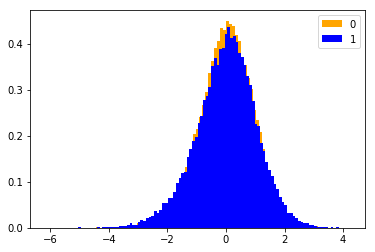

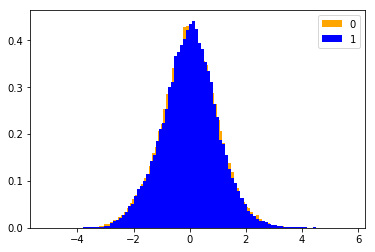

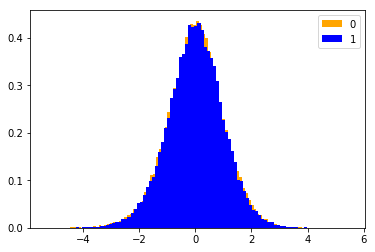

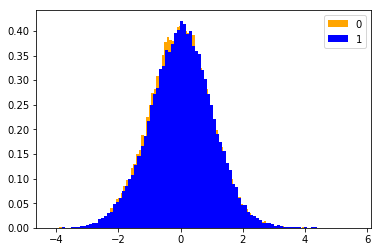

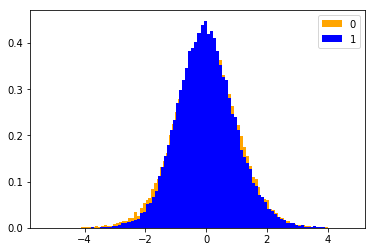

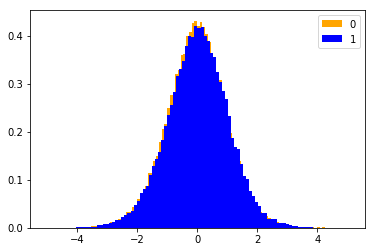

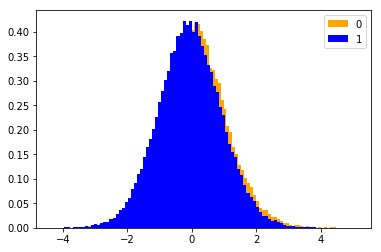

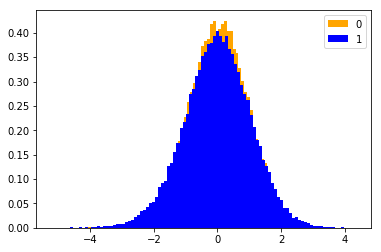

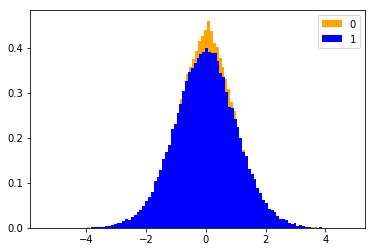

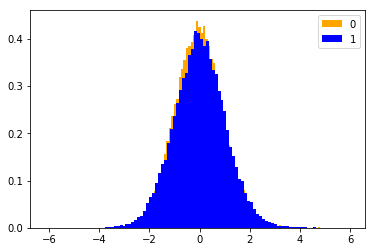

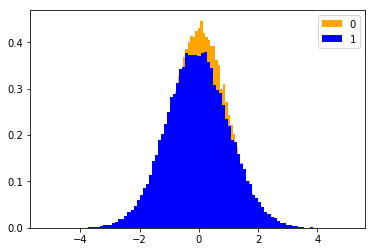

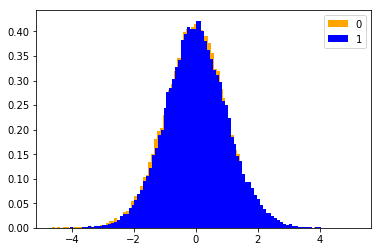

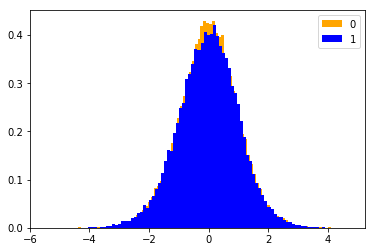

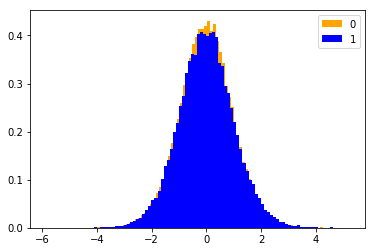

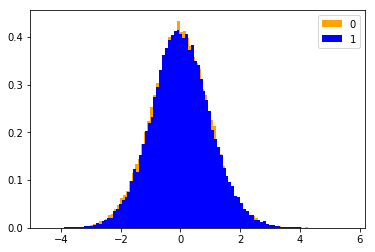

In [448]:
for i in range(100):
    plt.hist(embeds1[:, i], color='orange', bins=100, label='0', normed=True)
    plt.hist(embeds2[:, i], color='blue', bins=100, label='1', normed=True)
    plt.legend()
    plt.show()

In [449]:
import evaluation

In [450]:
def describe(sent_sampler, model, transformation):
    model.eval()
    x, mask, y = sent_sampler.get_test()
#     x, mask, y = sent_sampler.get_train_valid()
    true_y = np.zeros(shape=(len(y), len(sent_sampler.unique_labels)), dtype=np.int32)
    for idx, current_y in enumerate(y):
        true_y[idx, current_y] = 1
    
    x, mask, y = model.prepare_data_for_classifier(x, mask, y, transformation)
    
    if model.is_cuda:
        x = x.cuda()
        y = y.cuda()
        mask = mask.cuda()
    

    
    loss = model.classifier.get_loss(x, mask, y).data.cpu().numpy()
    probs = model.classifier(x, mask)[1].data.cpu().numpy()
    
    pred = np.argmax(probs, axis=1)
    
    acc = evaluation.accuracy(predicted_probs=probs, true_y=true_y)
    prec = {}
    rec = {}
    for cls in range(true_y.shape[1]):
        prec[cls] = evaluation.precision_by_class(probs, true_y, cls)
        rec[cls] = evaluation.recall_by_class(probs, true_y, cls)
    
    return acc, prec, rec, evaluation.build_confusion_matrix(probs, true_y)

    

In [451]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_1, cls, cls.transform1)

In [452]:
print(acc, len(sent_sampler_1.sents))

(695, 1024, 0.6787109375) 18641


In [453]:
print(acc, len(sent_sampler_1.sents))

(695, 1024, 0.6787109375) 18641


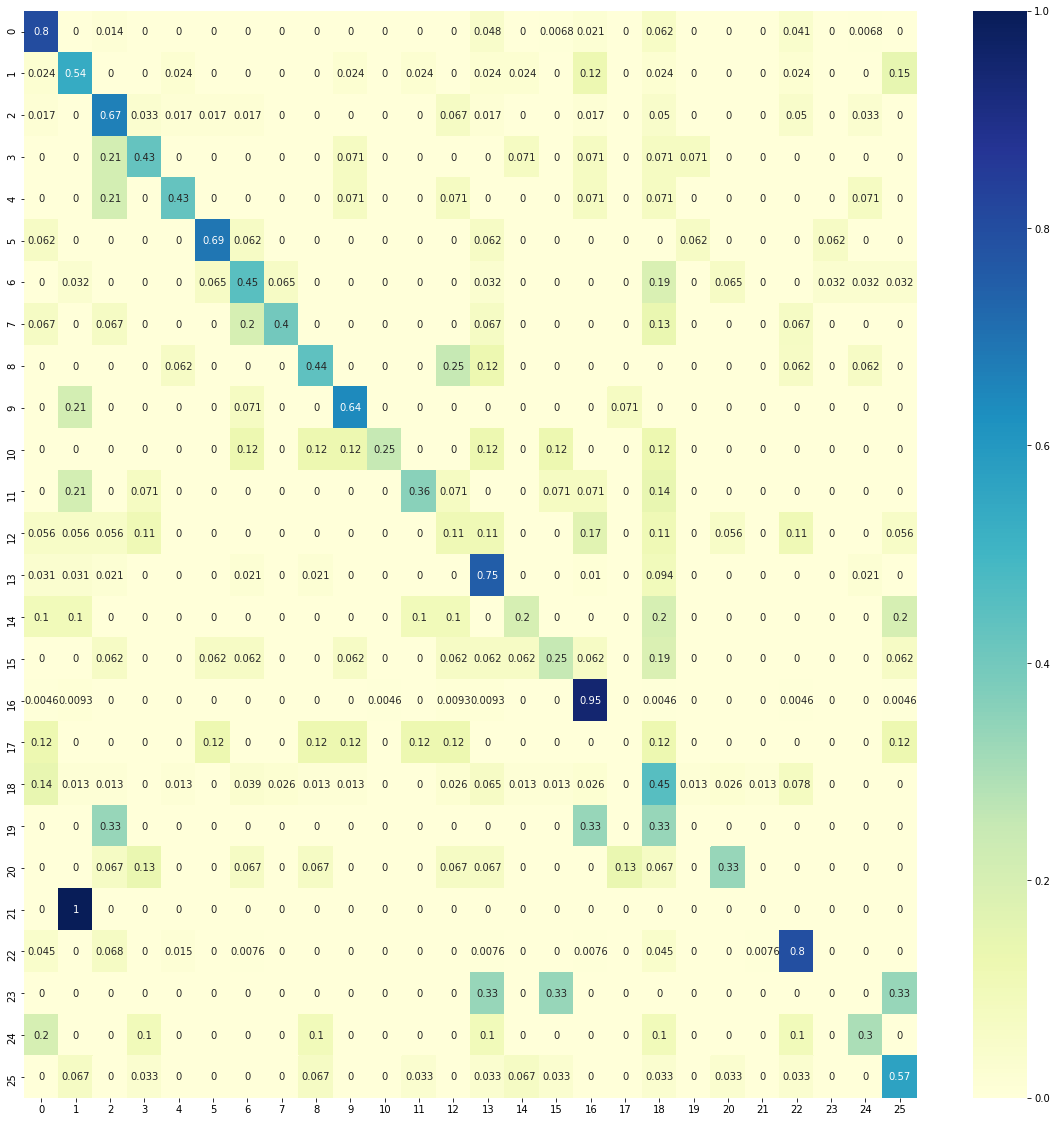

In [454]:
evaluation.plot_confusion_matrix(confusion_matrix)

In [455]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_2, cls, cls.transform2)

In [456]:
print(acc, len(sent_sampler_2.sents))

(675, 1024, 0.6591796875) 17860


In [457]:
print(acc, len(sent_sampler_2.sents))

(675, 1024, 0.6591796875) 17860


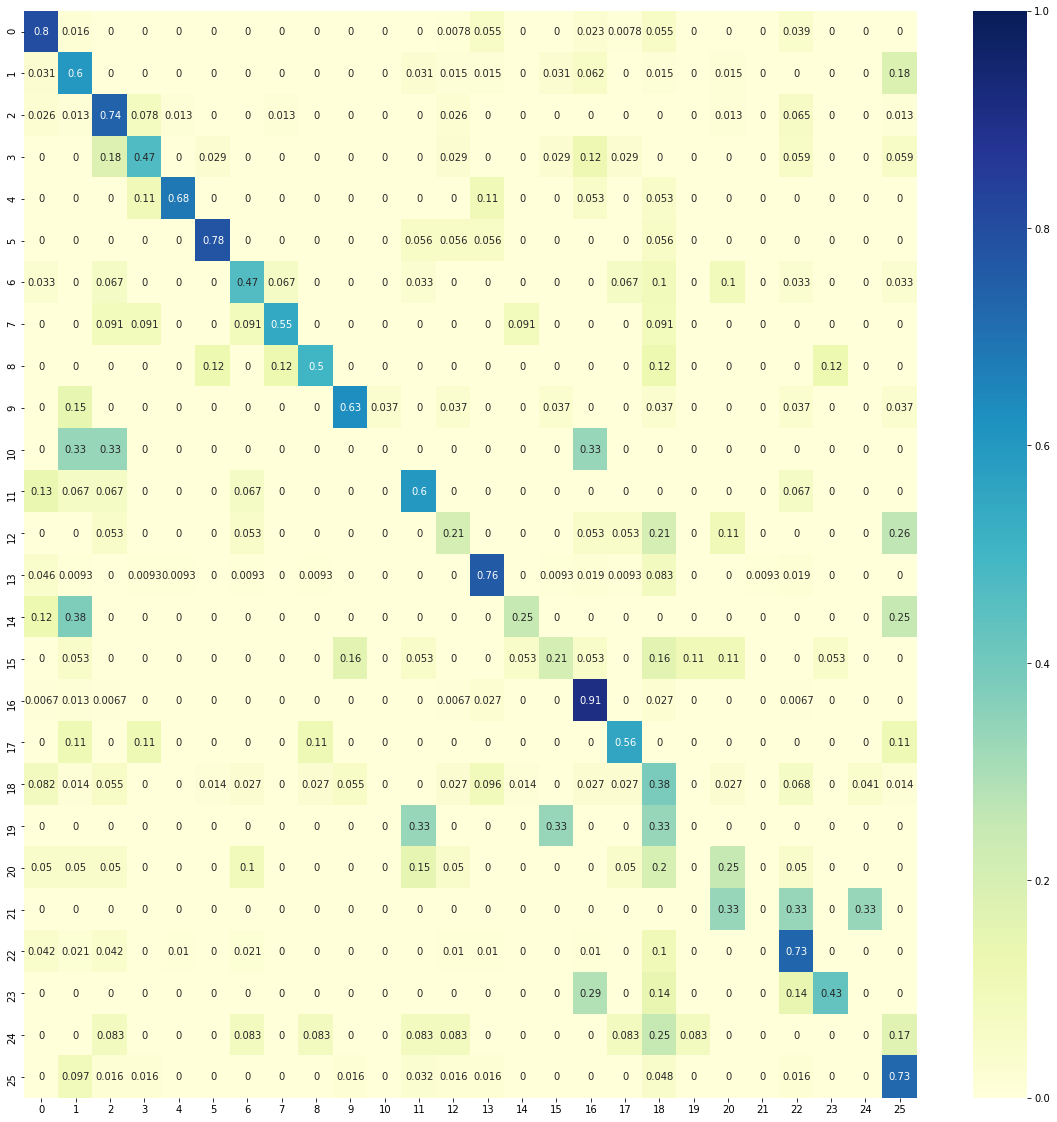

In [458]:
evaluation.plot_confusion_matrix(confusion_matrix)

In [459]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_1, cls, cls.transform2)

In [460]:
acc

(50, 1024, 0.048828125)

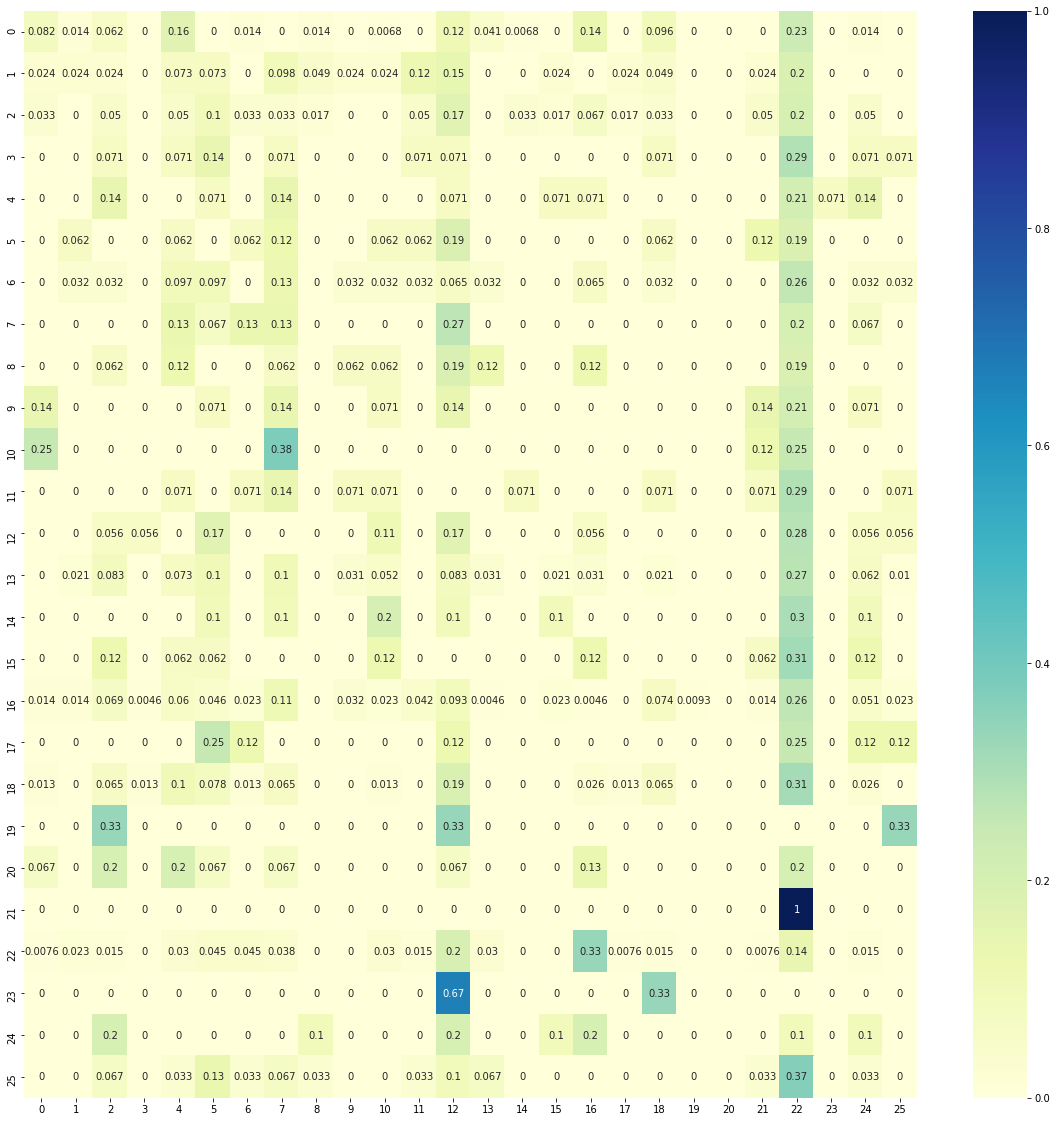

In [461]:
evaluation.plot_confusion_matrix(confusion_matrix)

In [462]:
acc, prec, rec, confusion_matrix = describe(sent_sampler_1, cls, model.IdentityTransformation())

In [463]:
acc

(56, 1024, 0.0546875)

In [464]:
f = """
aider
famille
groupe
regarder
posséder
président
haut
homme
venir
octobre
gros
chaque
chose
femme
trouver
publique
campagne
eau
gauche
bien
pays
jamais
"""
f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [465]:
# s ="""
# ayudar
# familia
# grupo
# mira
# poseer
# presidente
# alto
# hombre
# venir
# octubre
# grande
# cada
# cosa
# mujer
# encontrar
# público
# campaña
# agua
# izquierda
# bueno
# país
# nunca
# """

# s = [w.strip() for w in s.split("\n") if len(w) > 1]


s = """
help
family
group
look
own
president
high
man
come
october
big
every
thing
woman
find
public
campaign
water
left
good
country
never
"""
s = [w.strip() for w in s.split("\n") if len(w) > 1]

In [466]:
# def plot_word_by_id(t1, t2, e, f, ids, dims):
#     plt.figure(figsize=(20, 20))
# #     plt.scatter(t1[ids, 0], t1[ids, 1], color='r')
# #     plt.scatter(t2[ids, 0], t2[ids, 1], color='b')
#     plt.xlim(-3, 3)
#     plt.ylim(-3, 3)
#     for id in ids:
#         plt.annotate(e[id], (t1[id, dims[0]], t1[id, dims[1]]), color='r', fontsize=15)
#         plt.annotate(f[id], (t2[id, dims[0]], t2[id, dims[1]]), color='b', fontsize=15)
# #     plt.annotate(e)
# #         print(id)
#     plt.show()

In [467]:
def get_point(id, embeds, dims):
    return embeds[id, dims[0]], embeds[id, dims[1]]

def plot_word_by_id(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2, dims, hide_original=False):
    plt.figure(figsize=(20, 20))
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)
    ind_2 = vocab2.transform_one(lang_2)
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    for id, (w1, w2) in enumerate(zip(lang_1, lang_2)):
        if not hide_original:
            plt.annotate(w1, get_point(id, orig1, dims), color='black', fontsize=15)
            plt.annotate(w2, get_point(id, orig2, dims), color='grey', fontsize=15)
        plt.annotate(w1, get_point(id, t1, dims), color='r', fontsize=15)
        plt.annotate(w2, get_point(id, t2, dims), color='b', fontsize=15)

        
        
#     plt.annotate(e)
#         print(id)
    plt.show()

In [468]:
# plot_word_by_id(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, dims=[12, 49], hide_original=True)

In [469]:
# e = """
# help
# family
# group
# look
# own
# president
# high
# man
# come
# october
# big
# every
# thing
# woman
# find
# public
# campaign
# water
# left
# good
# country
# never
# """
# e = [w.strip() for w in e.split("\n") if len(w) > 1]

In [470]:
# f = """
# aider
# famille
# groupe
# regarder
# posséder
# président
# haut
# homme
# venir
# octobre
# gros
# chaque
# chose
# femme
# trouver
# publique
# campagne
# eau
# gauche
# bien
# pays
# jamais
# """
# f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [471]:
# cls = cls.cpu()
from sklearn.decomposition import PCA

In [472]:
def get_point_pca(id, embeds):
    return embeds[id, 0], embeds[id, 1]

def plot_words_pca(pca, vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2, hide_original=False):
    plt.figure(figsize=(20, 20))
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)
    ind_2 = vocab2.transform_one(lang_2)
    
    orig1 = pca.transform(orig1[ind_1])
    orig2 = pca.transform(orig2[ind_2])
    t1 = pca.transform(t1[ind_1])
    t2 = pca.transform(t2[ind_2])
    
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    for id, (w1, w2) in enumerate(zip(lang_1, lang_2)):
        
        if not hide_original:
            plt.annotate(w1, get_point_pca(id, orig1), color='black', fontsize=15)
            plt.annotate(w2, get_point_pca(id, orig2), color='grey', fontsize=15)
        plt.annotate(w1, get_point_pca(id, t1), color='r', fontsize=15)
        plt.annotate(w2, get_point_pca(id, t2), color='b', fontsize=15)
        
        
#     plt.annotate(e)
#         print(id)
    plt.show()

In [473]:
# pca1 = PCA(n_components=2)
# pca1.fit(vocab1.embeddings)

In [474]:
# pca2 = PCA(n_components=2)
# pca2.fit(vocab2.embeddings)

In [475]:
# pca3 = PCA(n_components=2)
# pca3.fit(embeds1)

In [479]:
# pca4 = PCA(n_components=2)
# pca4.fit(embeds2)

In [477]:
pca = PCA(n_components=2)
pca.fit(np.vstack([embeds1, embeds2]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

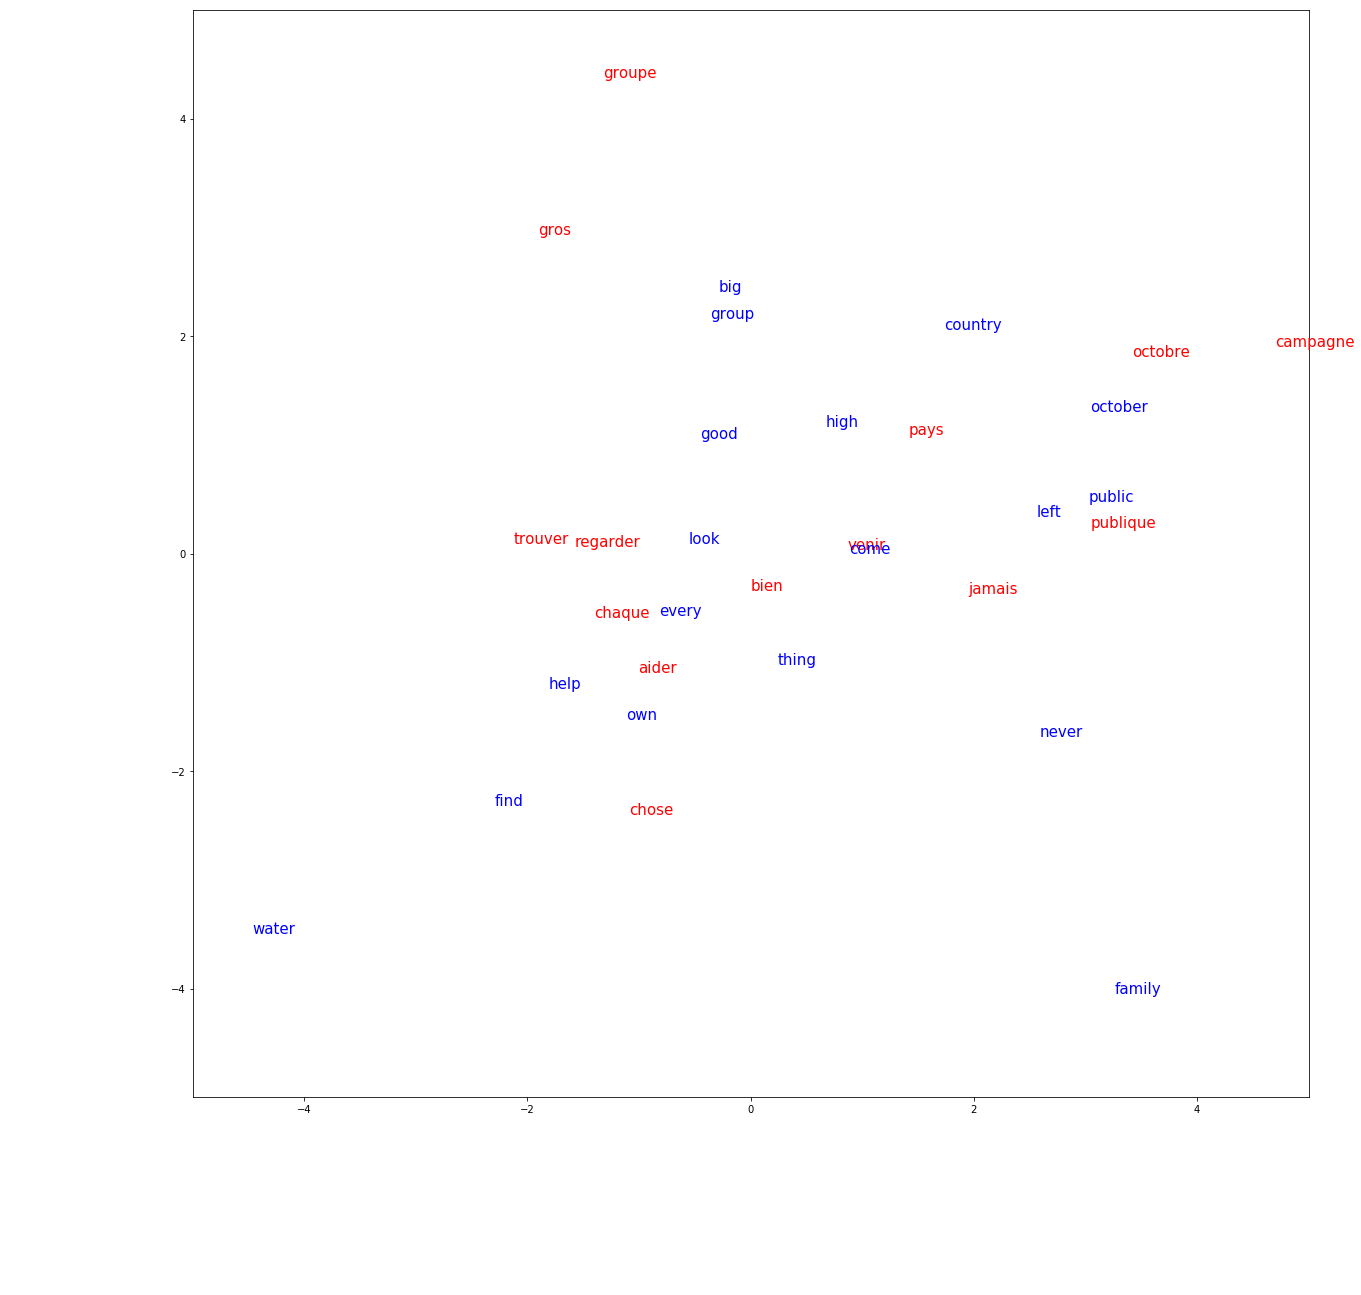

In [478]:
plot_words_pca(pca, vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, hide_original=True)

In [480]:
from sklearn.metrics.pairwise import cosine_similarity

In [481]:
import seaborn as sns

In [482]:
# f

In [483]:
def cos(a, b):
    a = a/(a**2).sum(axis=1, keepdims=True)**0.5
    b = b/(b**2).sum(axis=1, keepdims=True)**0.5
    
    return (a * b).sum(axis=1)

def cosine_metrics(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    before = cos(orig1, orig2)
    after = cos(t1, t2)
    
    print("{}|{}|{}|{}".format("lang1", "lang2", "before", "after", fill=' ', align='<', width=10))
    for w1, w2, c1, c2 in zip(lang_1, lang_2, before, after):
        print("{}|{}|{:.4f}|{:.4f}".format(w1, w2, c1, c2, fill=' ', align='<', width=10))
    
    c1 = cosine_similarity(orig1, orig2)
    c2 = cosine_similarity(t1, t2)
    plt.figure(figsize=(15, 15))
    sns.heatmap(c1, vmin=-1.0, vmax=1.0, square=True)
    plt.show()
    plt.figure(figsize=(15, 15))
    sns.heatmap(c2, vmin=-1.0, vmax=1.0, square=True)
    plt.show()
    
    plt.figure(figsize=(15, 15))
    sns.heatmap(c2 - c1)
    plt.show()
    
#     print(t1.shape, t2.shape)
#     print(c2.shape)
    s = 0
    for id, w1 in enumerate(lang_1):
#         print(c2[id].argmax())
        translation = lang_2[c2[id].argmax()]
        if translation == lang_2[id]:
            res = "OK"
        else:
            res = "Fail"
        s += translation == lang_2[id]
        print("{} --> {} ({})".format(w1, translation, res))
        
    print(s/len(lang_1))
#     plt.figure(figsize=(15, 15))
#     sns.heatmap((c2 - c1 > 0.1).astype(np.float32))
#     plt.show()
#     print(np.diag(c2))
#     print(np.diag(c1))
#     print()


In [484]:

def word_translation_cosine(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    c1 = cosine_similarity(orig1, orig2)
    c2 = cosine_similarity(t1, t2)
    
    count = 0
    for id, w1 in enumerate(lang_1):
        translation = lang_2[c2[id].argmax()]
        if translation == lang_2[id]:
            res = "OK"
        else:
            res = "Fail"
        count += translation == lang_2[id]
        print("{} --> {} ({})".format(w1, translation, res))
        
    print(count/len(lang_1))
    
    count = 0
    for id, w2 in enumerate(lang_2):
        translation = lang_1[c2[:, id].argmax()]
        if translation == lang_1[id]:
            res = "OK"
        else:
            res = "Fail"
        count += translation == lang_1[id]
        print("{} --> {} ({})".format(w2, translation, res))
        
    print(count/len(lang_2))



In [485]:
word_translation_cosine(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s)

aider --> find (Fail)
famille --> family (OK)
groupe --> group (OK)
regarder --> find (Fail)
posséder --> own (OK)
président --> president (OK)
haut --> high (OK)
homme --> woman (Fail)
venir --> every (Fail)
octobre --> october (OK)
gros --> group (Fail)
chaque --> every (OK)
chose --> find (Fail)
femme --> woman (OK)
trouver --> help (Fail)
publique --> public (OK)
campagne --> campaign (OK)
eau --> water (OK)
gauche --> president (Fail)
bien --> thing (Fail)
pays --> country (OK)
jamais --> never (OK)
0.5909090909090909
help --> trouver (Fail)
family --> famille (OK)
group --> groupe (OK)
look --> bien (Fail)
own --> chose (Fail)
president --> président (OK)
high --> octobre (Fail)
man --> homme (OK)
come --> bien (Fail)
october --> octobre (OK)
big --> groupe (Fail)
every --> chaque (OK)
thing --> bien (Fail)
woman --> femme (OK)
find --> chose (Fail)
public --> publique (OK)
campaign --> campagne (OK)
water --> eau (OK)
left --> octobre (Fail)
good --> bien (OK)
country --> pays (

lang1|lang2|before|after
aider|help|0.1497|0.5127
famille|family|-0.0352|0.5826
groupe|group|-0.0241|0.4649
regarder|look|0.0725|0.2464
posséder|own|0.0859|0.3210
président|president|0.0013|0.7237
haut|high|0.1111|0.2819
homme|man|0.0777|0.5249
venir|come|0.1197|0.3876
octobre|october|0.0307|0.5752
gros|big|-0.0656|0.4026
chaque|every|0.1538|0.5884
chose|thing|0.2506|0.4541
femme|woman|0.0529|0.7574
trouver|find|0.1031|0.4933
publique|public|0.1366|0.4876
campagne|campaign|-0.0845|0.6148
eau|water|-0.0158|0.5985
gauche|left|0.0135|0.0868
bien|good|0.0601|0.3569
pays|country|0.0388|0.5294
jamais|never|0.1138|0.5899


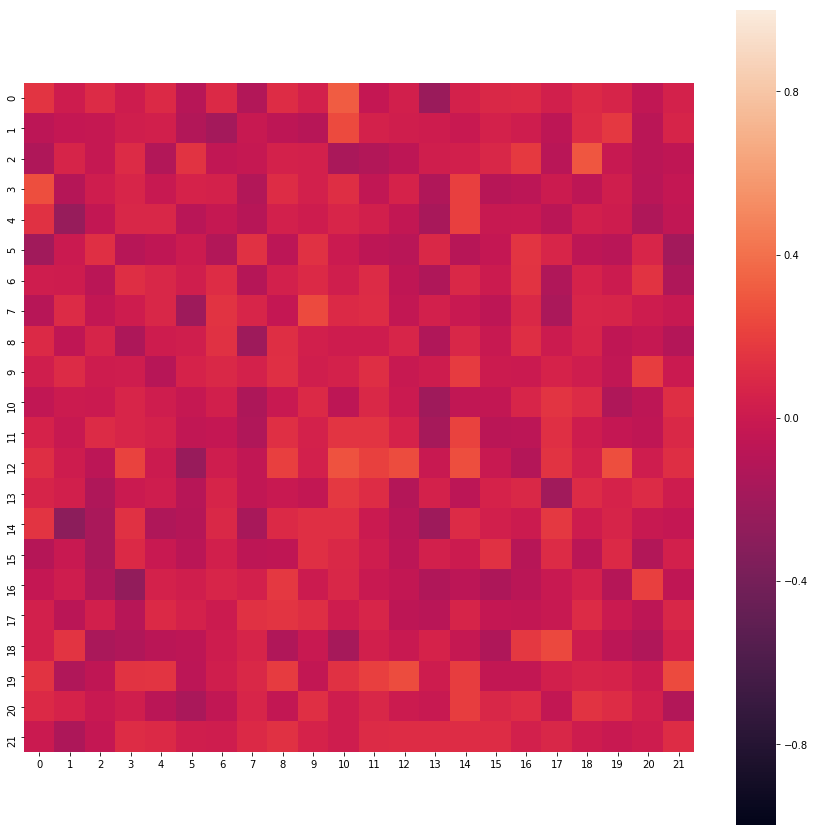

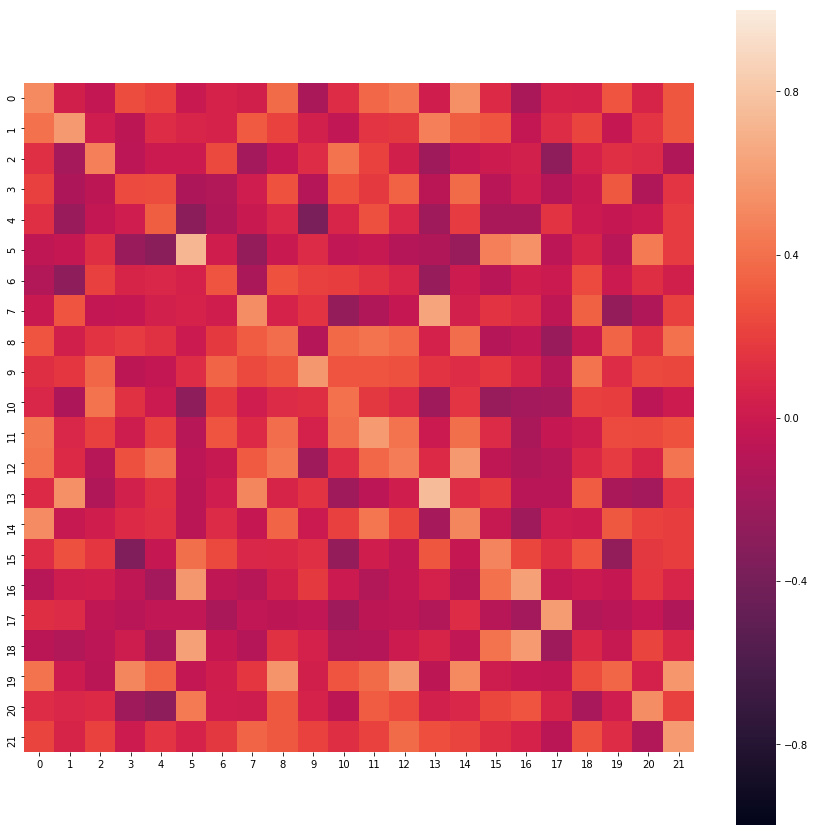

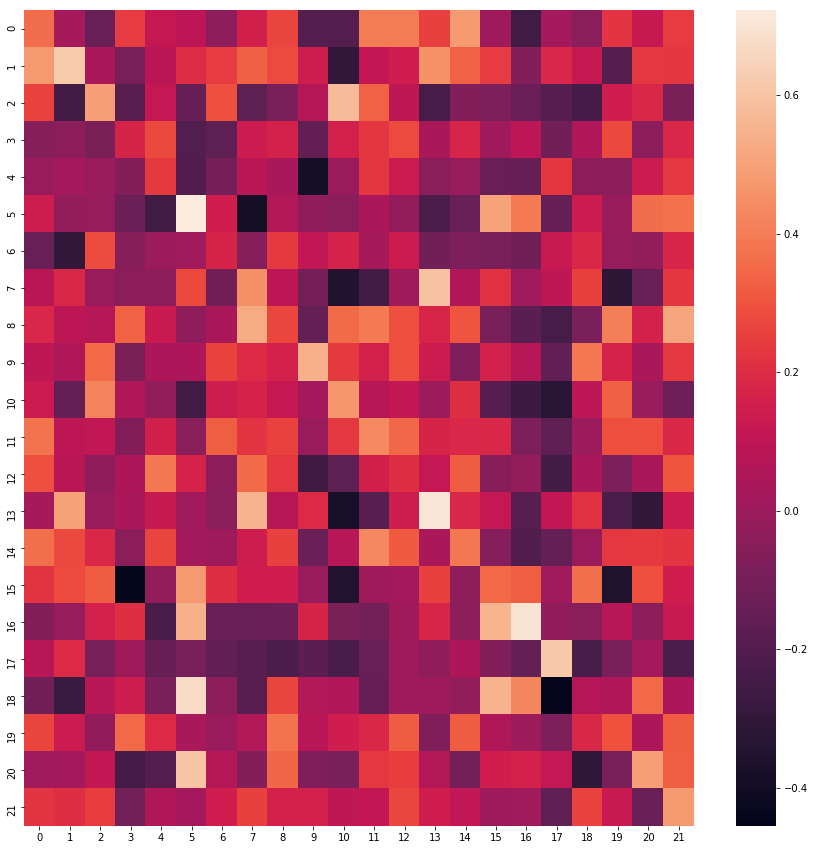

aider --> find (Fail)
famille --> family (OK)
groupe --> group (OK)
regarder --> find (Fail)
posséder --> own (OK)
président --> president (OK)
haut --> high (OK)
homme --> woman (Fail)
venir --> every (Fail)
octobre --> october (OK)
gros --> group (Fail)
chaque --> every (OK)
chose --> find (Fail)
femme --> woman (OK)
trouver --> help (Fail)
publique --> public (OK)
campagne --> campaign (OK)
eau --> water (OK)
gauche --> president (Fail)
bien --> thing (Fail)
pays --> country (OK)
jamais --> never (OK)
0.5909090909090909


In [486]:
cosine_metrics(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s)

In [487]:
# vocab1.transformation

In [488]:
import os
def read_facebook_dict(path, file_name, vocab1, vocab2):
    path = os.path.join(path, file_name)
    
    lang_1 = []
    lang_2 = []
    with open(path, "r") as f:
        for line in f:
            a, b = line.strip().split(" ")
            if a in vocab1.transformation and b in vocab2.transformation:
                lang_1.append(a)
                lang_2.append(b)
                
    return lang_1, lang_2

In [489]:
def word_translation_cosine_silent(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2,ks,  use_transformed=True,):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    if use_transformed:
        similarity = cosine_similarity(t1, t2)
    else:
        similarity = cosine_similarity(orig1, orig2)
        
    
    counts1 = {k:0 for k in ks}
    for id, w1 in enumerate(lang_1):
        candidate_ids = (-similarity[id]).argsort()
        for k in ks:
            if id in candidate_ids[:k]:
                counts1[k] += 1
        
    counts2 = {k:0 for k in ks}
    for id, w2 in enumerate(lang_2):
        candidate_ids = (-similarity[:, id]).argsort()
        for k in ks:
            if id in candidate_ids[:k]:
                counts2[k] += 1
        
#     res_for_lang_2 = count/len(lang_2)
    
#     return res_for_lang_1, res_for_lang_2
    for k in ks:
        counts1[k] /= len(lang_1)
        counts2[k] /= len(lang_2)
        
    return counts1, counts2


In [490]:
word_translation_cosine_silent(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500,1000, 2000])

({1: 0.5909090909090909,
  2: 0.8181818181818182,
  3: 0.8636363636363636,
  4: 0.8636363636363636,
  5: 0.8636363636363636,
  6: 0.8636363636363636,
  7: 0.9545454545454546,
  8: 1.0,
  9: 1.0,
  10: 1.0,
  50: 1.0,
  100: 1.0,
  200: 1.0,
  500: 1.0,
  1000: 1.0,
  2000: 1.0},
 {1: 0.5909090909090909,
  2: 0.7272727272727273,
  3: 0.8181818181818182,
  4: 0.9545454545454546,
  5: 0.9545454545454546,
  6: 0.9545454545454546,
  7: 0.9545454545454546,
  8: 0.9545454545454546,
  9: 0.9545454545454546,
  10: 0.9545454545454546,
  50: 1.0,
  100: 1.0,
  200: 1.0,
  500: 1.0,
  1000: 1.0,
  2000: 1.0})

In [491]:
lang_1, lang_2 = read_facebook_dict("../crosslingual/dictionaries/", "fr-en.5000-6500.txt", vocab1, vocab2)

In [492]:
word_translation_cosine_silent(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, lang_1, lang_2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500,1000, 2000])

({1: 0.0708502024291498,
  2: 0.11639676113360324,
  3: 0.14423076923076922,
  4: 0.16852226720647773,
  5: 0.18522267206477733,
  6: 0.19939271255060728,
  7: 0.21356275303643724,
  8: 0.229251012145749,
  9: 0.23937246963562753,
  10: 0.25303643724696356,
  50: 0.458502024291498,
  100: 0.5713562753036437,
  200: 0.680668016194332,
  500: 0.8375506072874493,
  1000: 0.9387651821862348,
  2000: 1.0},
 {1: 0.06376518218623482,
  2: 0.1082995951417004,
  3: 0.13815789473684212,
  4: 0.16548582995951416,
  5: 0.18775303643724697,
  6: 0.20394736842105263,
  7: 0.21862348178137653,
  8: 0.23026315789473684,
  9: 0.24139676113360323,
  10: 0.2515182186234818,
  50: 0.45799595141700405,
  100: 0.5743927125506073,
  200: 0.6766194331983806,
  500: 0.8390688259109311,
  1000: 0.9342105263157895,
  2000: 1.0})

In [493]:
def word_translation_cosine_complete(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2,ks,  use_transformed=True,):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    orig1_complete = orig1
    orig2_complete = orig2
    t1_complete = t1
    t2_complete = t2
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    if use_transformed:
        similarity_1_2 = cosine_similarity(t1, t2_complete)
        similarity_2_1 = cosine_similarity(t2, t1_complete)
    else:
        similarity_1_2 = cosine_similarity(orig1, orig2_complete)
        similarity_2_1 = cosine_similarity(orig2, orig1_complete)
        
    
    counts1 = {k:0 for k in ks}
    for id, w1 in enumerate(lang_1):
        translation_id = vocab2.words.index(lang_2[id])
        candidate_ids = (-similarity_1_2[id]).argsort()
        for k in ks:
            if translation_id in candidate_ids[:k]:
                counts1[k] += 1
        
    counts2 = {k:0 for k in ks}
    for id, w2 in enumerate(lang_2):
        translation_id = vocab1.words.index(lang_1[id])
        candidate_ids = (-similarity_2_1[id]).argsort()
        for k in ks:
            if translation_id in candidate_ids[:k]:
                counts2[k] += 1
        
#     res_for_lang_2 = count/len(lang_2)
    
#     return res_for_lang_1, res_for_lang_2
    for k in ks:
        counts1[k] /= len(lang_1)
        counts2[k] /= len(lang_2)
        
    return counts1, counts2


In [494]:
# word_translation_cosine_complete(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, lang_1, lang_2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], use_transformed=False)

In [495]:
word_translation_cosine_complete(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, lang_1, lang_2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], use_transformed=True)

({1: 0.010121457489878543,
  2: 0.019736842105263157,
  3: 0.025303643724696356,
  4: 0.030364372469635626,
  5: 0.034919028340080975,
  6: 0.03896761133603239,
  7: 0.043522267206477734,
  8: 0.048582995951417005,
  9: 0.05212550607287449,
  10: 0.05566801619433198,
  50: 0.13714574898785425,
  100: 0.18319838056680163,
  200: 0.2353238866396761,
  500: 0.33653846153846156,
  1000: 0.42813765182186236,
  2000: 0.5389676113360324,
  5000: 0.6857287449392713,
  10000: 0.8046558704453441,
  20000: 0.9124493927125507,
  50000: 1.0},
 {1: 0.012145748987854251,
  2: 0.020242914979757085,
  3: 0.02834008097165992,
  4: 0.03694331983805668,
  5: 0.04251012145748988,
  6: 0.046052631578947366,
  7: 0.05212550607287449,
  8: 0.056174089068825914,
  9: 0.058704453441295545,
  10: 0.06325910931174089,
  50: 0.13663967611336034,
  100: 0.1862348178137652,
  200: 0.25101214574898784,
  500: 0.3532388663967611,
  1000: 0.4407894736842105,
  2000: 0.5460526315789473,
  5000: 0.6907894736842105,
  100

In [496]:
dp.write_embeds("./embeds_fr.vec", embeds1, vocab1.words)

In [497]:
dp.write_embeds("./embeds_en.vec", embeds2, vocab2.words)

In [498]:
s = """
2010
2011
2012
2013
2014
2015
2016
2017
2018
january
february
march
april
may
june
july
august
september
october
november
december
"""
s = [w.strip() for w in s.split("\n") if len(w) > 1]

In [499]:
f = """
2010
2011
2012
2013
2014
2015
2016
2017
2018
janvier
février
mars
avril
mai
juin
juillet
aout
septembre
octobre
novembre
décembre
"""
f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [500]:
word_translation_cosine_complete(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], use_transformed=True)

({1: 0.047619047619047616,
  2: 0.047619047619047616,
  3: 0.09523809523809523,
  4: 0.09523809523809523,
  5: 0.09523809523809523,
  6: 0.14285714285714285,
  7: 0.14285714285714285,
  8: 0.19047619047619047,
  9: 0.19047619047619047,
  10: 0.19047619047619047,
  50: 0.47619047619047616,
  100: 0.7619047619047619,
  200: 0.9047619047619048,
  500: 0.9523809523809523,
  1000: 1.0,
  2000: 1.0,
  5000: 1.0,
  10000: 1.0,
  20000: 1.0,
  50000: 1.0},
 {1: 0.047619047619047616,
  2: 0.09523809523809523,
  3: 0.09523809523809523,
  4: 0.09523809523809523,
  5: 0.09523809523809523,
  6: 0.09523809523809523,
  7: 0.09523809523809523,
  8: 0.19047619047619047,
  9: 0.19047619047619047,
  10: 0.23809523809523808,
  50: 0.38095238095238093,
  100: 0.38095238095238093,
  200: 0.6666666666666666,
  500: 0.9523809523809523,
  1000: 1.0,
  2000: 1.0,
  5000: 1.0,
  10000: 1.0,
  20000: 1.0,
  50000: 1.0})

In [501]:
word_translation_cosine(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s)

2010 --> june (Fail)
2011 --> july (Fail)
2012 --> july (Fail)
2013 --> july (Fail)
2014 --> july (Fail)
2015 --> march (Fail)
2016 --> march (Fail)
2017 --> 2018 (Fail)
2018 --> 2018 (OK)
janvier --> april (Fail)
février --> march (Fail)
mars --> march (OK)
avril --> 2010 (Fail)
mai --> march (Fail)
juin --> march (Fail)
juillet --> 2012 (Fail)
aout --> 2015 (Fail)
septembre --> september (OK)
octobre --> march (Fail)
novembre --> november (OK)
décembre --> march (Fail)
0.19047619047619047
2010 --> 2015 (Fail)
2011 --> 2014 (Fail)
2012 --> 2014 (Fail)
2013 --> 2015 (Fail)
2014 --> 2015 (Fail)
2015 --> 2015 (OK)
2016 --> 2016 (OK)
2017 --> 2017 (OK)
2018 --> 2017 (Fail)
january --> janvier (OK)
february --> janvier (Fail)
march --> 2015 (Fail)
april --> janvier (Fail)
may --> 2016 (Fail)
june --> 2015 (Fail)
july --> 2014 (Fail)
august --> 2014 (Fail)
september --> 2015 (Fail)
october --> octobre (OK)
november --> novembre (OK)
december --> janvier (Fail)
0.2857142857142857


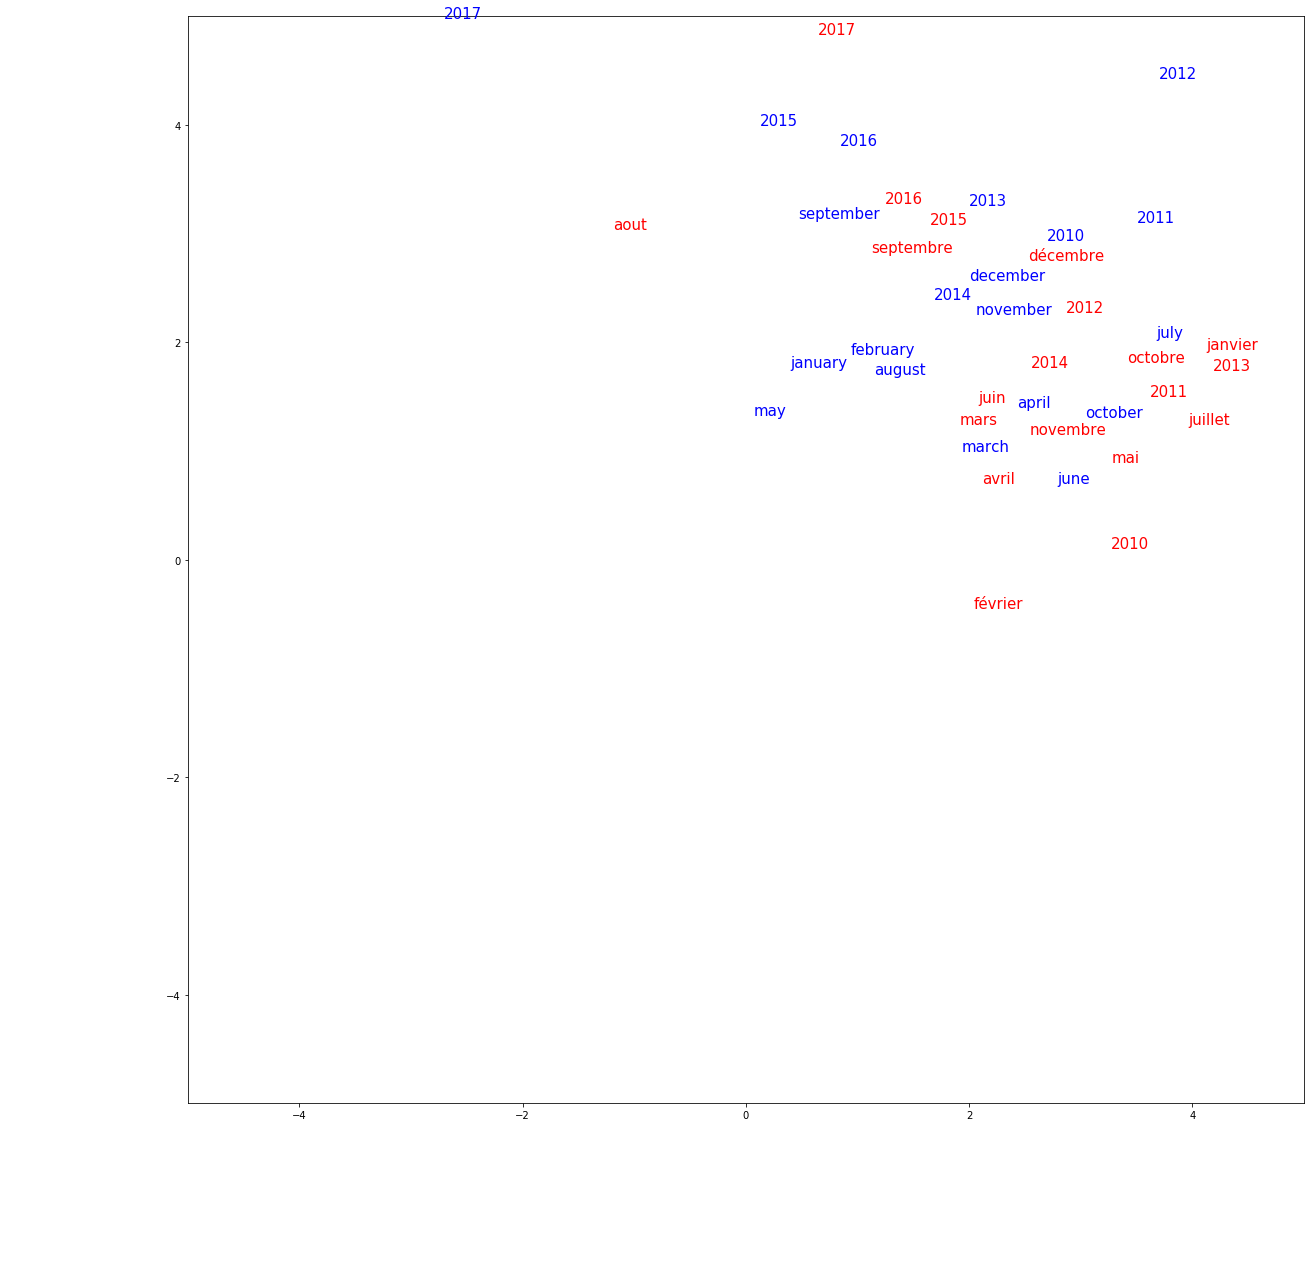

In [502]:
plot_words_pca(pca, vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, hide_original=True)